# Определение возраста покупателей
Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

## Исследовательский анализ данных

In [34]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [39]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Видим, что данные полны и представляют из себя названия файла с фото и возраст человека на фото.

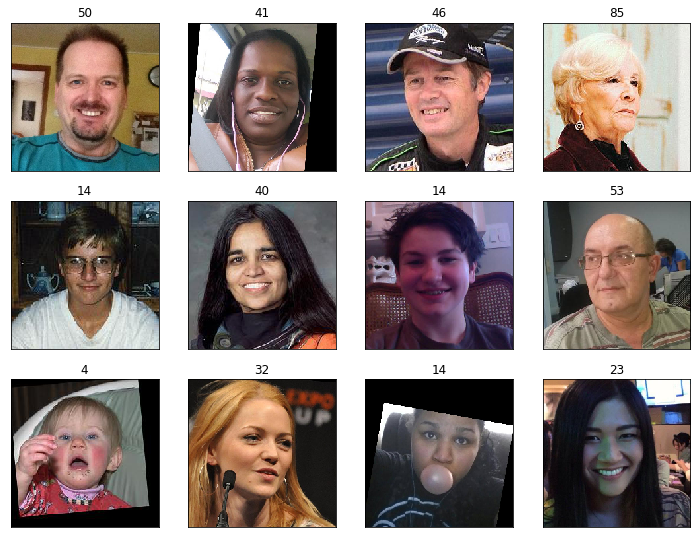

In [41]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [13]:
features[0].shape

(224, 224, 3)

Мы видим перед собой изображения людей в профиль и фас, фото не "документные" - у людей есть очки, или даже пузырь от жевачки. Есть фотографии, которые покрутили вокруг своей оси. Размер фото 224x224, цветное.

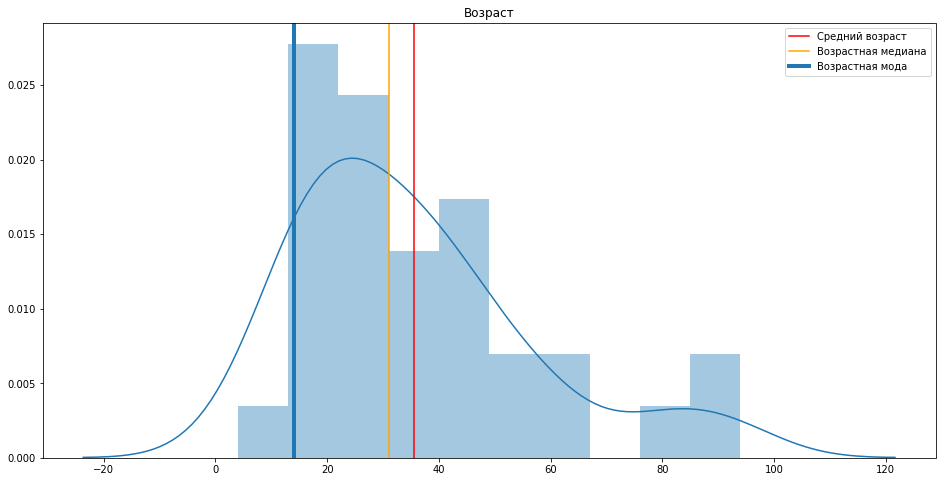

In [43]:

plt.figure(figsize = (16, 8))

sns.distplot(target, bins = 10)

plt.axvline(target.mean(), label='Средний возраст',  color = 'red')
plt.axvline(np.median(target), label='Возрастная медиана',  color = 'orange')
plt.axvline(stats.mode(target)[0][0], label='Возрастная мода',  linewidth=4)


plt.title('Возраст')
plt.legend()
plt.show()

In [45]:
print(f'минимальный возраст - {target.min()}, максимальный - {target.max()}')

минимальный возраст - 4, максимальный  -94


Наши данные не идеальны - возраст участников от 4 до 94, больше всего 14-летних учасников и мы видим явный провал в возрасте от примерно 65 до 78 лет. 

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.25,
                                       vertical_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_data = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory=path + 'final_files/',
                                                   x_col='file_name', y_col='real_age',
                                                   target_size=(244, 244),
                                                   batch_size=16,
                                                   class_mode='raw',
                                                   subset='training',
                                                   seed=12345)
    return train_data


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path + 'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(244, 244),
                                                 batch_size=16,
                                                 class_mode='raw',
                                                 subset='validation',
                                                 seed=12345)
    return test_data


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet',
                        include_top=False)
    model = Sequential()
    optimizer = Adam(learning_rate=0.0001)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data,
                batch_size=None, epochs=20,
                steps_per_epoch=None,
                validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model


```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
2021-07-27 21:44:53.526014: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-27 21:44:53.806095: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 105s - loss: 227.3756 - mae: 11.2319 - val_loss: 386.5002 - val_mae: 14.7365
Epoch 2/20
356/356 - 98s - loss: 128.5789 - mae: 8.6885 - val_loss: 136.6839 - val_mae: 9.0362
Epoch 3/20
356/356 - 98s - loss: 107.3842 - mae: 7.9761 - val_loss: 123.5264 - val_mae: 8.0906
Epoch 4/20
356/356 - 98s - loss: 94.6529 - mae: 7.3954 - val_loss: 91.0844 - val_mae: 7.1592
Epoch 5/20
356/356 - 98s - loss: 84.3542 - mae: 6.9642 - val_loss: 85.0905 - val_mae: 6.9906
Epoch 6/20
356/356 - 98s - loss: 77.2108 - mae: 6.6855 - val_loss: 94.8821 - val_mae: 7.5072
Epoch 7/20
356/356 - 98s - loss: 69.8013 - mae: 6.4123 - val_loss: 93.7408 - val_mae: 7.3404
Epoch 8/20
356/356 - 98s - loss: 63.7981 - mae: 6.1127 - val_loss: 103.9106 - val_mae: 7.4307
Epoch 9/20
356/356 - 98s - loss: 57.7675 - mae: 5.8595 - val_loss: 81.8374 - val_mae: 6.7535
Epoch 10/20
356/356 - 98s - loss: 52.9487 - mae: 5.6141 - val_loss: 91.3077 - val_mae: 6.9483
Epoch 11/20
356/356 - 98s - loss: 47.2461 - mae: 5.3216 - val_loss: 102.0848 - val_mae: 7.2521
Epoch 12/20
356/356 - 98s - loss: 54.0473 - mae: 5.6070 - val_loss: 145.8099 - val_mae: 9.6623
Epoch 13/20
356/356 - 98s - loss: 51.4271 - mae: 5.4665 - val_loss: 97.5857 - val_mae: 7.6491
Epoch 14/20
356/356 - 98s - loss: 44.0511 - mae: 5.0699 - val_loss: 91.9312 - val_mae: 7.0297
Epoch 15/20
356/356 - 98s - loss: 41.4018 - mae: 4.9180 - val_loss: 77.2088 - val_mae: 6.4480
Epoch 16/20
356/356 - 98s - loss: 34.3841 - mae: 4.5685 - val_loss: 83.4304 - val_mae: 6.7625
Epoch 17/20
356/356 - 98s - loss: 34.9140 - mae: 4.5988 - val_loss: 82.7365 - val_mae: 6.7890
Epoch 18/20
356/356 - 98s - loss: 34.2103 - mae: 4.4907 - val_loss: 77.8743 - val_mae: 6.6735
Epoch 19/20
356/356 - 98s - loss: 30.9176 - mae: 4.2814 - val_loss: 74.0968 - val_mae: 6.3422
Epoch 20/20
356/356 - 98s - loss: 28.3201 - mae: 4.1206 - val_loss: 73.7302 - val_mae: 6.3156
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 73.7302 - mae: 6.3156
Test MAE: 6.3156



```

## Анализ обученной модели

Модель в среднем ошибается на 6,3 года, что довольно неплохо (я уверена, что справилась бы хуже), имея в распоряжении всего 7591 фотографий. Обучающую выборку мы смогли немного увеличить с помошью вертикального отражения и сдвига вправо и влево. Мы использовали загрузчик данных ImageDataGenerator для загрузки таких объемных данных, как картинки, далее мы передавли их в модель на основе архитектуры ResNet50, с оптимизатором Adam.
С помощью этой системы планировалось:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.
По первому пункту: кажется это излишним. Более легко провести такой анализ с помощью карты постоянного покупателя - это намного дешевле. Карту обычно выдают с указанием возраста, если по этому признаку хочется сделать рекомендацию.
Второй пункт тоже кажется сомнительным. Снимок с предъявленным паспортом мне представляется также более дешевым методом контроля.